# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
import project_tests as t

In [3]:
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [4]:
# Show df to get an idea of the data
df.head(3)

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074


In [5]:
# Show df_content to get an idea of the data
df_content.head(3)

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [6]:
# Get interaction counts
counts_interaction = df['email'].value_counts().sort_values(ascending= False)
counts_interaction.head()

2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
Name: email, dtype: int64

''

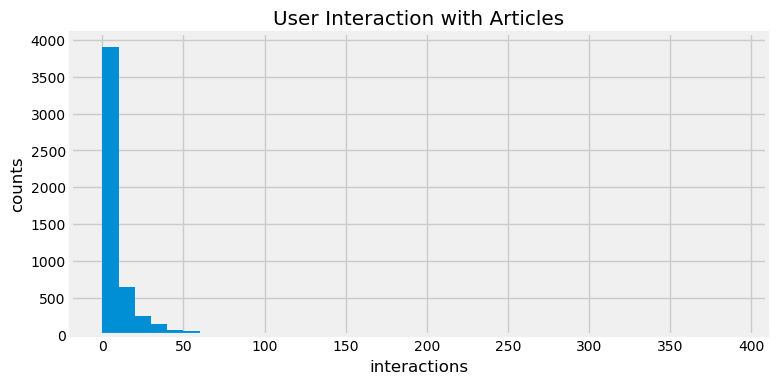

In [7]:
plt.figure(figsize= (8, 4), dpi= 100)
bins= np.arange(0, 400, 10)
plt.hist(counts_interaction.values, bins= bins)
plt.title('User Interaction with Articles')
plt.xlabel('interactions')
plt.ylabel('counts')
;

In [8]:
# Fill in the median and maximum number of user_article interactios below

median_val = np.median(counts_interaction.values)
# The maximum number of user-article interactions by any 1 user
max_views_by_user = np.max(counts_interaction.values)

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [9]:
# Get how many articles are duplicated
df_content['article_id'].duplicated().sum()

5

In [10]:
# Remove any rows that have the same article_id - only keep the first.
print(f'Number of rows before duplicate removal is {df_content.shape[0]}.')
# Removes all the duplicates, keeps the first one by default
df_content.drop_duplicates(['article_id'], inplace= True) # default: keep= 'first'
print(f'Number of rows after duplicate removal is {df_content.shape[0]}.')

Number of rows before duplicate removal is 1056.
Number of rows after duplicate removal is 1051.


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [11]:
a = len(set(df['article_id']))
b = len(set(df_content['article_id']))
c = df['email'].nunique()
#d = counts_interaction.values.sum() # count only if `email` is not `nan`
d = len(df)
print(f'Number of unique articles that have an interaction with a user: {a}')
print(f'Number of unique articles in the dataset (with or w/o interactions): {b}')
print(f'Number of unique users in the dataset (excluding null values): {c}')
print(f'Number of user-article interactions in the dataset: {d}')

Number of unique articles that have an interaction with a user: 714
Number of unique articles in the dataset (with or w/o interactions): 1051
Number of unique users in the dataset (excluding null values): 5148
Number of user-article interactions in the dataset: 45993


In [12]:
unique_articles = a # The number of unique articles that have at least one interaction
total_articles = b # The number of unique articles on the IBM platform
unique_users = c # The number of unique users
user_article_interactions = d # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [13]:
counts_articles_view = df['article_id'].value_counts()
counts_articles_view.head()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

In [14]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id = str(counts_articles_view.index[0])
# The most viewed article in the dataset was viewed how many times?
max_views = counts_articles_view.values[0]

print(f'Most viewd article is {most_viewed_article_id}; '
      f'it has been viewd {max_views} times.')

Most viewd article is 1429.0; it has been viewd 937 times.


In [15]:
def email_mapper():
    """ Maps the user email to a user_id column."""
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded


In [16]:
email_encoded = email_mapper()
# Remove the email column.
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [17]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [18]:
def get_top_articles(n, df= df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['title'].value_counts().index.values   
    # Return the top article titles from df
    return top_articles[:n]

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = df['article_id'].value_counts().index
    # Convert to string -- it's just a requirement.
    top_articles = [str(ix) for ix in top_articles]
    # Return the top article ids
    return top_articles[:n]

In [19]:
print(get_top_articles(10))

['use deep learning for image classification'
 'insights from new york car accident reports'
 'visualize car data with brunel'
 'use xgboost, scikit-learn & ibm watson machine learning apis'
 'predicting churn with the spss random tree algorithm'
 'healthcare python streaming application demo'
 'finding optimal locations of new store using decision optimization'
 'apache spark lab, part 1: basic concepts'
 'analyze energy consumption in buildings'
 'gosales transactions for logistic regression model']


In [20]:
print(get_top_article_ids(10))

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [21]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [22]:
# Get 4 sample rows.
# Remember: `email` has been mapped in the dataframe.
df.sample(4, random_state= 0)

,article_id,title,user_id
44847,1017.0,the pandas data analysis library,5048
4949,1296.0,fortune 100 companies,1327
38980,607.0,recommendation system algorithms – stats and bots,4381
31332,969.0,flightpredict ii: the sequel – ibm watson dat...,3616


In [23]:
def create_user_item_matrix(df):
    """ Create the user-article matrix with 1's and 0's.
    
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns
    with 1 values where a user interacted with an article and a 0 otherwise
    """
    user_item = df.pivot_table(index='user_id', columns='article_id',
                               aggfunc= len, fill_value= 0)
    
    # We are only interested in if interaction happened or not.
    #=> Convert valus g.t. 1 to 1 (i.e., interaction happened.)
    user_item[user_item > 1] = 1
    
    # Return the user_item matrix 
    return user_item


In [24]:
user_item = create_user_item_matrix(df)

In [25]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [26]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # Compute similarity of each user to the provided user
    ncols = user_item.shape[1]
    dfsim = user_item.dot(np.reshape(user_item.loc[user_id].values, (ncols, 1)))
    sim = dfsim.values.flatten()
    dfsim = pd.DataFrame({'user_id': user_item.index, 'similarity_score': sim})

    # Sort by similarity
    dfsim = dfsim.sort_values(by= 'similarity_score', ascending= False)
    # Remove the own user's id
    dfsim = dfsim.loc[dfsim['user_id'] != user_id]

    # Create list of just the ids
    most_similar_users = dfsim['user_id'].values
    
    # Return a list of the users in order from most to least similar
    return most_similar_users


In [27]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are:\n{}".format(find_similar_users(1)[:10]))
print('=' * 60)
print("The 5 most similar users to user 3933 are:\n{}".format(find_similar_users(3933)[:5]))
print('=' * 60)
print("The 3 most similar users to user 46 are:\n{}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are:
[3933   23 3782  203 4459 3870  131 4201   46 5041]
The 5 most similar users to user 3933 are:
[   1   23 3782  203 4459]
The 3 most similar users to user 46 are:
[4201 3782   23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [28]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = df.loc[df['article_id'].isin(article_ids), 'title'].values
    # Remove duplicates.
    article_names = list(set(article_names))
    
    # Return the article names associated with list of article ids
    return article_names


def get_user_articles(user_id, user_item= user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    user_info = user_item.loc[user_id]
    article_ids = [str(itm[1]) for itm in (user_info[user_info > 0]).index]
    article_names = get_article_names(article_ids)
    
    # return the ids and names
    return article_ids, article_names


def user_user_recs(user_id, m= 10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Get the articles' id that the user already viewed.
    articles_ids_viewed, _ = get_user_articles(user_id)
    
    # Get most similar users to the user_id
    users_similar = find_similar_users(user_id)
    
    # Initialize recommendations.
    recs = set()
    # Loop over the articles viewed by similar users.
    for user in users_similar:
        # Get the articles that user has viewed already.
        article_ids, _ = get_user_articles(user)
        new_recs = set(article_ids)
        # Update the recommendations based on the new found articles.
        recs.update(new_recs)
        # Remove the articles already viewd from the recommendations.
        recs = recs - set(articles_ids_viewed)
        
        # If m recommendations already found, return:
        if len(recs) >= m:
            break
        
    # Return m recommendations as a list, for the user_id
    recs = list(recs)[:m]
    return recs


In [29]:
# Return 10 recommendations for user 1
get_article_names(user_user_recs(1, 10))

['process events from the watson iot platform in a streams python application',
 '1448    i ranked every intro to data science course on...\nName: title, dtype: object',
 'visualising data the node.js way',
 'deep learning from scratch i: computational graphs',
 'recent trends in recommender systems',
 'optimizing a marketing campaign: moving from predictions to actions',
 'machine learning exercises in python, part 1',
 'perform sentiment analysis with lstms, using tensorflow',
 'analyzing data by using the sparkling.data library features',
 'maximize oil company profits']

In [30]:
# Test the functions.
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [31]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    dict_neighbors = {}
    for user in user_item.index:
        if user == user_id:
            continue
        # Get similarity
        sim = np.dot(user_item.loc[user_id, :], user_item.loc[user, :])
        n_interactions = df[df['user_id']==user]['article_id'].count()
        dict_neighbors[user] = [sim, n_interactions]
    # Convert the neighbors info to DataFrame.
    df_neighbors = pd.DataFrame(dict_neighbors).T.reset_index()
    # Set the column names appropriately.
    df_neighbors.columns = ['neighbor_id', 'similarity', 'num_interactions']
    
    # Sort by similarity and number of interactions.
    df_neighbors.sort_values(['similarity', 'num_interactions'],
                             ascending= False,
                             inplace= True)
    
    return df_neighbors


def user_user_recs_part2(user_id, m= 10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Initialize recommendations.
    recs = set()
    # Get the most similar users.
    df_neighbors = get_top_sorted_users(user_id)
    # Get the articles viewed by the user.
    articles_id, _ = get_user_articles(user_id)
    
    # First look for recommendations from most similar users.
    for neighbor in df_neighbors['neighbor_id']:
        # Get the articles viewed by the neighbor.
        articles_id_neighbors, _ = get_user_articles(neighbor)
        
        articles_to_recom = set(articles_id) - set(articles_id_neighbors)
        # Update the recommendation list.
        recs.update(articles_to_recom)
        # We only need m requirements.
        if len(recs) > m:
            break 
    
    # If still not enough recommendations found
    # Then look for recommendations from most similar articles viewed.
    if len(recs) < m:
        # Get the rest of recommendation list from top articles.
        # Add extra `len(articles_id)` jsut in case the user's viewed articles
        # are themselves within top articles.
        articles_to_recom = get_top_article_ids(m - len(recs) + len(articles_id))
        # Update the recommendation list.
        recs.update(articles_to_recom)
        
    
    # Get the recommended article names.
    recs = list(recs)
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [32]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:\n")
print(rec_ids)
print('=-' * 60)
print()
print("The top 10 recommendations for user 20 are the following article names:\n")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:

['1304.0', '1320.0', '844.0', '232.0', '1293.0', '1314.0', '1170.0', '1429.0', '1330.0', '1364.0', '1431.0', '1162.0', '1427.0']
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

The top 10 recommendations for user 20 are the following article names:

['gosales transactions for logistic regression model', 'use deep learning for image classification', 'self-service data preparation with ibm data refinery', 'visualize car data with brunel', 'finding optimal locations of new store using decision optimization', 'use the cloudant-spark connector in python notebook', 'predicting churn with the spss random tree algorithm', 'apache spark lab, part 1: basic concepts', 'insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'housing (2015): united states demographic measures', 'healthcare python strea

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [33]:
### Tests with a dictionary of results

# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1).iloc[0]['neighbor_id']

# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131).iloc[9]['neighbor_id']

In [34]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.** Since we won't be having any useful information about the user, we could recommend only the most viewed articles.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [35]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?
# As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)

In [36]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

In [37]:
def make_content_recs():
    """Make content recommendations."""
    pass

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

In [38]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [39]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [40]:
# Have a quick look at some part of the matrix.
user_item_matrix.iloc[[97,  664,  693, 1058, 1171, 3123, 3763, 4483], :18]

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,1017.0,1018.0,102.0,1024.0,1025.0,1028.0,103.0,1030.0
user_id,,,,,,,,,,,,,,,,,,
98,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
694,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1172,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3124,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3764,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4484,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [41]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix)

**Provide your response here.** By design `user_item_matrix` has no missing values. It's a binary matrix, meaning that if any interaction exists, then 1, otherwise it's populated with 0. `SDV` cannot handle missing values.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

''

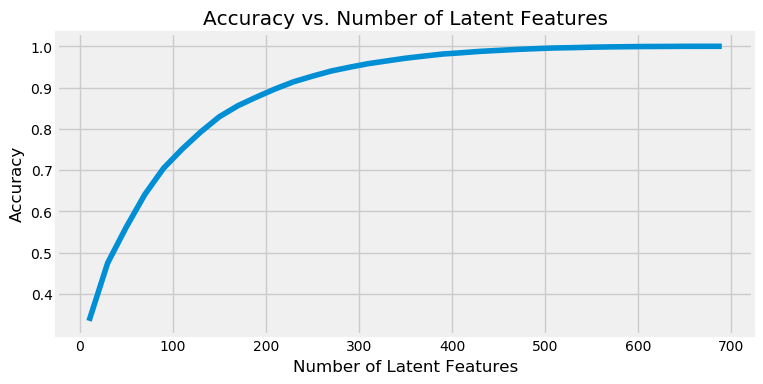

In [42]:
num_latent_feats = np.arange(10, 700+10, 20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
plt.figure(figsize= (8, 4), dpi= 100)
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0])
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features')
;

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [43]:
# Create training and test sets.
df_train = df.head(40000)
df_test = df.tail(5993)

In [44]:
def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Create user-item-matrix for train and test set.
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    # Get user_ids & article ids for test set.
    test_idx = user_item_test.index.values
    test_arts = [itm[1] for itm in user_item_test.columns.values]
    
    return user_item_train, user_item_test, test_idx, test_arts


In [45]:
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [46]:
# Make sure the dimensions are okay.
user_item_train.shape, user_item_test.shape

((4487, 714), (682, 574))

In [47]:
# Replace the values in the dictionary below
a = len(np.setdiff1d(user_item_test.index, user_item_train.index)) # 662
d = len(np.setdiff1d(user_item_test.columns, user_item_train.columns)) # 0 
b = user_item_test.shape[1] - d # 574 
c = user_item_test.shape[0] - a # 20 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [48]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices= False)

#### Check how well you can use the training decomposition to predict on test data

In [49]:
# Get the shape of outpus from training.
u_train.shape, s_train.shape, vt_train.shape

((4487, 714), (714,), (714, 714))

In [50]:
common_idx = user_item_train.index.isin(test_idx)
common_arts = user_item_train.title.columns.isin(test_arts)

u_test = u_train[common_idx, :]
vt_test = vt_train[:, common_arts]

s_new, u_new, vt_new = np.diag(s_train[:10]), u_train[:, :10], vt_train[:10, :]
u_test_new, vt_test_new = u_test[:, :10], vt_test[:10, :]

# Make prediction.
user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

''

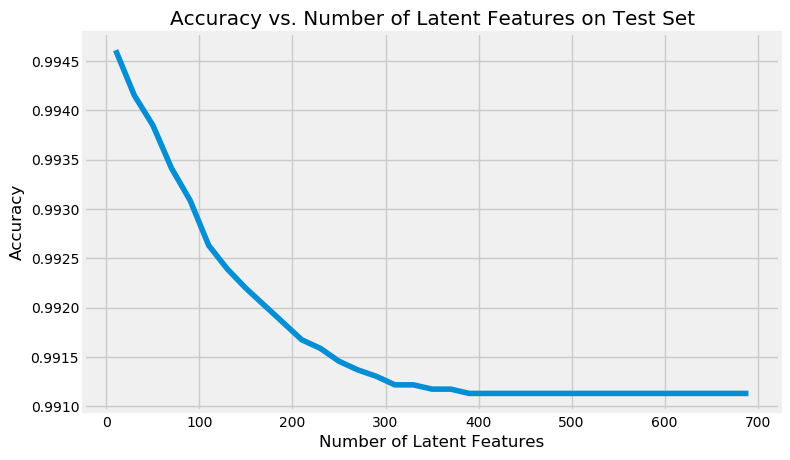

In [51]:
num_latent_feats = np.arange(10, 700+10, 20)
sum_err, sum_err_test = [], []

for k in num_latent_feats:
    # Restructure with k latent features.
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    # Make prediction.
    user_item_test_est = np.around(np.dot(np.dot(u_test_new, s_new), vt_test_new))
    
    # Compute error for each prediction to actual value.
    user_item_test_matrix = user_item_test.loc[user_item_matrix.loc[common_idx, :].index, :]
    test_diffs = np.subtract(user_item_test_matrix, user_item_test_est)
    
    # total errors and keep track of them
    test_err = np.sum(np.sum(np.abs(test_diffs)))
    sum_err_test.append(test_err)


plt.figure(figsize= (8, 5), dpi= 100)
plt.plot(num_latent_feats, 1 - np.array(sum_err_test) / df.shape[0])
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features on Test Set')
;

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

- Although the accuracy is high, we have to consider that the matrix is mostly consisted of zeros, i.e., no interaction than 1.    

- With the increase in the number of latent variables, the testset accuracy decreases. The reason is that %96.6 of the users are new and we are not able to make predictions for them -- so-called `cold start problem`. And by no means is 20 users enough so that our ML-based approach could have generalization power. This could be the reason behind the decrease in testset accuracy with the increase in the number of latent variables (when model gets more complicated, it also detects noise as singnal.)

- As a result, the train-test approach is not viable to evaulate the predictive power of our recommendation engine. Methods such as A/B testing could come handy. 

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!

In [52]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0